In [0]:
%pip install s3fs
%pip install wordcloud
%pip install gensim
%pip install --upgrade --force-reinstall numpy==1.22.0

Python interpreter will be restarted.
  Using cached s3fs-2023.3.0-py3-none-any.whl (27 kB)
  Using cached aiohttp-3.8.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached fsspec-2023.3.0-py3-none-any.whl (145 kB)
  Using cached aiobotocore-2.4.2-py3-none-any.whl (66 kB)
  Using cached aioitertools-0.11.0-py3-none-any.whl (23 kB)
  Using cached botocore-1.27.59-py3-none-any.whl (9.1 MB)
  Using cached frozenlist-1.3.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (158 kB)
  Using cached yarl-1.8.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (264 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached multidict-6.0.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.32
    Not uninstalling botocore at /databricks/python3/

In [0]:
import pandas as pd
from wordcloud import WordCloud

In [0]:
# Load dataset
df = pd.read_csv(".../control_fg_ccf_scf.csv", header=0)

In [0]:
df_fg = df[df["source"]=="fieldguide"].copy()
df_ccf = df[df["source"]=="ccf"].copy()
df_scf = df[df["source"]=="scf"].copy() # SCF is already filtered to the same framework as ccf

df_fg.shape, df_ccf.shape, df_scf.shape

Out[39]: ((49442, 8), (218, 8), (1090, 8))

# WordCloud

## 1. FieldGuide

In [0]:
long_string = ','.join(df_fg['control'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=400, height=300
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## 2. CCF

In [0]:
long_string = ','.join(df_ccf['control'].tolist())
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=400, height=300
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## 2. SCF

In [0]:
# long_string = ','.join(df_scf['control'].tolist())
# SCF text also starts with "Mechanisms exist". remove it to see other words
long_string = ','.join(
    list(df_scf['control'].apply(lambda x:x.replace("Mechanisms exist", "").replace("mechanisms exist", "")).values)
)

# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=400, height=300
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Statistic Measure (OPTIONAL)

In [0]:
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

# Top Modeling

In [0]:
import gensim
from gensim.utils import simple_preprocess
import nltk
import gensim.corpora as corpora
from gensim import models
from pprint import pprint
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from gensim.models.coherencemodel import CoherenceModel
from matplotlib import pyplot as plt

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def build_corpus(df):
    # Remove punctuation
    df['control_processed'] = df['control'].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert the titles to lowercase
    df['control_processed'] = df['control_processed'].map(lambda x: x.lower())

    # Tokenization
    texts = df["control_processed"].tolist()
    texts_words = list(sent_to_words(texts))

    # Remove stop words
    texts_words = remove_stopwords(texts_words)
    
    # Create Dictionary
    id2word = corpora.Dictionary(texts_words)

    # Remove tokens appear less than 10 times and in more than 90% of the docs
    id2word.filter_extremes(no_below=10, no_above=0.5)

    # Create Corpus
    corpus = [id2word.doc2bow(text) for text in texts_words]
    # print(corpus[:1][0][:30])

    return texts_words, id2word, corpus

def tuning_best_LDA(max_num_topics, texts_words, corpus, id2word):
    candidate_models = []
    MAX_NUM_TOPICS = 15
    for n in range(2, max_num_topics + 1):
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n, passes=5, iterations=100)

        # Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 
        # These measurements help distinguish between topics that are semantically interpretable topics 
        # and topics that are artifacts of statistical inference.
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_words, dictionary=id2word, coherence='c_v')
        coherence = coherence_model_lda.get_coherence()
        candidate_models.append((n, lda_model, coherence))
        print("num topic: ", n, 'Coherence Score: ', coherence)
    return candidate_models

def plot_coherence_score(num_topics, scores):
    plt.plot(range(2, num_topics+1), scores)
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence Score')
    # plt.savefig('elbow.png')
    plt.show()
    
def get_topic_distribution(model, dictionary, text):
    text_processed = remove_stopwords(sent_to_words([text]))[0]
    
    corpus = dictionary.doc2bow(text_processed)
    topics = model[corpus]

    # sort topics by prop
    topics = sorted(topics, key=lambda x: (x[1]), reverse=True)
    result_dict = []
    for i, (topic_id, prop_topic) in enumerate(topics):
        wp = model.show_topic(topic_id)
        
        topic_keywords = "_".join([word for word, prop in wp])
        result_dict.append({"topic_index":topic_id, "topic_prob": round(prop_topic,4), "topic_keywords": topic_keywords})
    return result_dict

def assign_topic_prediction(model, df, id2word):
    df["gensim_topics"] = df['control_processed'].apply(lambda x: get_topic_distribution(model, id2word, x))
    df["gensim_topic_tp1"] = df["gensim_topics"].apply(lambda x: x[0])
    df["gensim_tp1_topic_id"] = df["gensim_topic_tp1"].apply(lambda x: x['topic_index'])
    df["gensim_tp1_topic_prob"] = df["gensim_topic_tp1"].apply(lambda x: x['topic_prob'])
    df["gensim_tp1_topic_keywords"] = df["gensim_topic_tp1"].apply(lambda x: x['topic_keywords'])
    
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## CCF

In [0]:
texts_words_ccf, id2word_ccf, corpus_ccf = build_corpus(df_ccf)

In [0]:
MAX_NUM_TOPICS = 12
candidate_models = tuning_best_LDA(MAX_NUM_TOPICS, texts_words_ccf, corpus_ccf, id2word_ccf)

num topic:  2 Coherence Score:  0.3104005371921613
num topic:  3 Coherence Score:  0.2882890116428869
num topic:  4 Coherence Score:  0.28363964302429157
num topic:  5 Coherence Score:  0.2806929696320097
num topic:  6 Coherence Score:  0.3055260584349747
num topic:  7 Coherence Score:  0.3168691672251938
num topic:  8 Coherence Score:  0.2906080651784942
num topic:  9 Coherence Score:  0.291098692762942
num topic:  10 Coherence Score:  0.29449920710998584
num topic:  11 Coherence Score:  0.3132153288169101
num topic:  12 Coherence Score:  0.29614494860422996


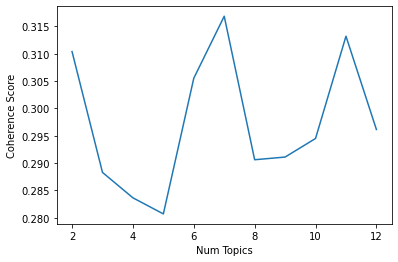

In [0]:
plot_coherence_score(MAX_NUM_TOPICS, [m[2] for m in candidate_models])

In [0]:
best_model_num_topics, best_model, best_model_conherence = sorted(candidate_models, key=lambda x: (x[2]), reverse=True)[0]
print(best_model_num_topics, best_model, best_model_conherence)

# Print the Keyword in the 10 topics
pprint(best_model.print_topics())

7 LdaMulticore<num_terms=52, num_topics=7, decay=0.5, chunksize=2000> 0.3168691672251938
[(0,
  '0.202*"management" + 0.122*"audit" + 0.078*"plan" + 0.077*"risk" + '
  '0.056*"production" + 0.054*"control" + 0.039*"environment" + '
  '0.036*"defined" + 0.034*"results" + 0.032*"prior"'),
 (1,
  '0.175*"security" + 0.149*"information" + 0.092*"requirements" + '
  '0.057*"process" + 0.051*"network" + 0.043*"system" + 0.042*"defined" + '
  '0.034*"risk" + 0.032*"following" + 0.030*"systems"'),
 (2,
  '0.084*"criteria" + 0.077*"defined" + 0.075*"data" + 0.069*"authorized" + '
  '0.063*"accordance" + 0.061*"security" + 0.057*"personnel" + '
  '0.054*"frequency" + 0.044*"management" + 0.037*"reviewed"'),
 (3,
  '0.123*"access" + 0.119*"security" + 0.093*"use" + 0.089*"required" + '
  '0.086*"applicable" + 0.074*"business" + 0.068*"information" + '
  '0.037*"devices" + 0.032*"systems" + 0.031*"critical"'),
 (4,
  '0.161*"defined" + 0.145*"accordance" + 0.135*"frequency" + 0.058*"access" + '
  

In [0]:
for topic_id, keywords in best_model.print_topics():
    print("Topic: ", topic_id + 1)
    print(keywords)
    print()

Topic:  1
0.061*"system" + 0.052*"security" + 0.033*"components" + 0.023*"information" + 0.021*"systems" + 0.016*"processing" + 0.015*"utilize" + 0.015*"changes" + 0.014*"identify" + 0.014*"services"

Topic:  2
0.037*"services" + 0.033*"third" + 0.032*"systems" + 0.028*"party" + 0.027*"service" + 0.027*"organization" + 0.025*"applications" + 0.024*"ensure" + 0.021*"security" + 0.018*"time"

Topic:  3
0.071*"data" + 0.044*"sensitive" + 0.029*"network" + 0.029*"regulated" + 0.027*"integrity" + 0.022*"protect" + 0.018*"ensure" + 0.018*"cryptographic" + 0.017*"information" + 0.016*"confidentiality"

Topic:  4
0.037*"systems" + 0.032*"automated" + 0.030*"access" + 0.028*"devices" + 0.022*"organization" + 0.022*"information" + 0.021*"control" + 0.020*"use" + 0.019*"users" + 0.015*"defined"

Topic:  5
0.074*"privacy" + 0.057*"cybersecurity" + 0.036*"controls" + 0.026*"facilitate" + 0.025*"implementation" + 0.024*"regulatory" + 0.023*"applicable" + 0.021*"technologies" + 0.021*"statutory" + 0.

In [0]:
df_ccf = assign_topic_prediction(best_model, df_ccf, id2word_ccf)

In [0]:
df_ccf.groupby(["gensim_tp1_topic_id", "control_category"]).agg({"control": "count"})\
    .reset_index().pivot(index="control_category", columns="gensim_tp1_topic_id", values="control")\
#     .reset_index() #.sort_values(by=[i for i in range(best_model_num_topics)])

gensim_tp1_topic_id,0,1,2,3,4,5,6
control_category,,,,,,,
Asset Management,2.0,NaN,1.0,1.0,2.0,2.0,NaN
Backup Management,NaN,NaN,NaN,NaN,2.0,NaN,1.0
Business Continuity,NaN,NaN,1.0,2.0,2.0,1.0,NaN
Change Management,NaN,1.0,NaN,NaN,NaN,3.0,NaN
Configuration Management,1.0,1.0,2.0,2.0,1.0,2.0,1.0
Data Management,NaN,1.0,6.0,3.0,1.0,2.0,3.0
Entity Management,3.0,3.0,NaN,NaN,4.0,NaN,NaN
Identity and Access Management,2.0,1.0,NaN,6.0,7.0,11.0,8.0
Identity and Management,NaN,NaN,NaN,NaN,1.0,NaN,NaN


## SCF

In [0]:
texts_words_scf, id2word_scf, corpus_scf = build_corpus(df_scf)

In [0]:
MAX_NUM_TOPICS = 12
candidate_models = tuning_best_LDA(MAX_NUM_TOPICS, texts_words_scf, corpus_scf, id2word_scf)

num topic:  2 Coherence Score:  0.20149035106142738
num topic:  3 Coherence Score:  0.21859920425455512
num topic:  4 Coherence Score:  0.2377271560010087
num topic:  5 Coherence Score:  0.2639935786435951
num topic:  6 Coherence Score:  0.25948539899970563
num topic:  7 Coherence Score:  0.28003255021331835
num topic:  8 Coherence Score:  0.28736008584063505
num topic:  9 Coherence Score:  0.26722916148868503
num topic:  10 Coherence Score:  0.2738706624142565
num topic:  11 Coherence Score:  0.28450054038369604
num topic:  12 Coherence Score:  0.2708312456013709


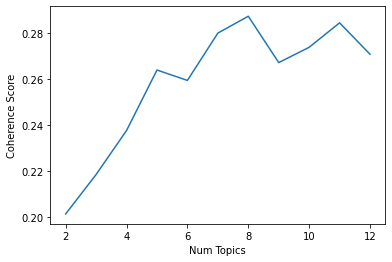

In [0]:
plot_coherence_score(MAX_NUM_TOPICS, [m[2] for m in candidate_models])

In [0]:
best_model_num_topics, best_model, best_model_conherence = sorted(candidate_models, key=lambda x: (x[2]), reverse=True)[0]
print(best_model_num_topics, best_model, best_model_conherence)

# Print the Keyword in the 10 topics
pprint(best_model.print_topics())

8 LdaMulticore<num_terms=294, num_topics=8, decay=0.5, chunksize=2000> 0.28736008584063505
[(0,
  '0.061*"system" + 0.052*"security" + 0.033*"components" + '
  '0.023*"information" + 0.021*"systems" + 0.016*"processing" + '
  '0.015*"utilize" + 0.015*"changes" + 0.014*"identify" + 0.014*"services"'),
 (1,
  '0.037*"services" + 0.033*"third" + 0.032*"systems" + 0.028*"party" + '
  '0.027*"service" + 0.027*"organization" + 0.025*"applications" + '
  '0.024*"ensure" + 0.021*"security" + 0.018*"time"'),
 (2,
  '0.071*"data" + 0.044*"sensitive" + 0.029*"network" + 0.029*"regulated" + '
  '0.027*"integrity" + 0.022*"protect" + 0.018*"ensure" + '
  '0.018*"cryptographic" + 0.017*"information" + 0.016*"confidentiality"'),
 (3,
  '0.037*"systems" + 0.032*"automated" + 0.030*"access" + 0.028*"devices" + '
  '0.022*"organization" + 0.022*"information" + 0.021*"control" + 0.020*"use" '
  '+ 0.019*"users" + 0.015*"defined"'),
 (4,
  '0.074*"privacy" + 0.057*"cybersecurity" + 0.036*"controls" + '
  

In [0]:
df_scf = assign_topic_prediction(best_model, df_scf, id2word_scf)

In [0]:
df_scf.groupby(["gensim_tp1_topic_id", "control_category"]).agg({"control": "count"})\
    .reset_index().pivot(index="control_category", columns="gensim_tp1_topic_id", values="control")\
#     .reset_index() #.sort_values(by=[i for i in range(best_model_num_topics)])

gensim_tp1_topic_id,0,1,2,3,4,5,6,7
control_category,,,,,,,,
Asset Management,5.0,11.0,13.0,6.0,4.0,NaN,5.0,12.0
Business Continuity and Disaster Recovery,18.0,9.0,5.0,9.0,1.0,NaN,4.0,4.0
Capacity and Performance Planning,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN
Change Management,5.0,NaN,2.0,3.0,4.0,NaN,2.0,1.0
Cloud Security,NaN,3.0,3.0,NaN,5.0,NaN,1.0,6.0
Compliance,2.0,NaN,1.0,NaN,7.0,NaN,3.0,NaN
Configuration Management,6.0,2.0,3.0,6.0,1.0,NaN,1.0,8.0
Continuous Monitoring,12.0,13.0,5.0,6.0,4.0,6.0,4.0,16.0
Cryptographic Protections,1.0,1.0,16.0,2.0,2.0,NaN,2.0,3.0


## FieldGuide

In [0]:
import re
def standardize_redaction(text):
    res_text = re.sub('XXX+', '[The organization]', text)
    res_text = re.sub('AAA+', '[The organization]', res_text)
    res_text = re.sub('\[The organization\]', '', res_text)
    return res_text

print(df_fg[df_fg['control'].apply(lambda x: "XXXXXXXX" in x)]['control'].count())
print(df_fg[df_fg['control'].apply(lambda x: "AAAAAAAA" in x)]['control'].count())

df_fg['control'] = df_fg['control'].apply(standardize_redaction)

0
0


In [0]:
texts_words_fg, id2word_fg, corpus_fg = build_corpus(df_fg)

In [0]:
MAX_NUM_TOPICS = 12
candidate_models = tuning_best_LDA(MAX_NUM_TOPICS, texts_words_fg, corpus_fg, id2word_fg)

num topic:  2 Coherence Score:  0.39594692500084727
num topic:  3 Coherence Score:  0.3337708124198456
num topic:  4 Coherence Score:  0.4268062731777861
num topic:  5 Coherence Score:  0.4050546290934844
num topic:  6 Coherence Score:  0.4519321411795388
num topic:  7 Coherence Score:  0.442035564517094
num topic:  8 Coherence Score:  0.39306044751022085
num topic:  9 Coherence Score:  0.4194583635658054
num topic:  10 Coherence Score:  0.4505817092405839
num topic:  11 Coherence Score:  0.44668545283611877
num topic:  12 Coherence Score:  0.471997764931632


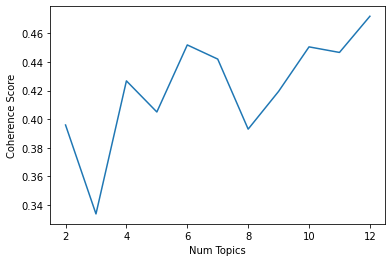

In [0]:
plot_coherence_score(MAX_NUM_TOPICS, [m[2] for m in candidate_models])

In [0]:
best_model_num_topics, best_model, best_model_conherence = sorted(candidate_models, key=lambda x: (x[2]), reverse=True)[0]
print(best_model_num_topics, best_model, best_model_conherence)

# Print the Keyword in the 10 topics
pprint(best_model.print_topics())

12 LdaMulticore<num_terms=2921, num_topics=12, decay=0.5, chunksize=2000> 0.471997764931632
[(0,
  '0.104*"organization" + 0.090*"defined" + 0.062*"frequency" + '
  '0.057*"accordance" + 0.038*"management" + 0.036*"reviewed" + '
  '0.030*"according" + 0.022*"standards" + 0.021*"approved" + '
  '0.020*"communicated"'),
 (1,
  '0.045*"information" + 0.032*"system" + 0.022*"systems" + 0.015*"scans" + '
  '0.015*"security" + 0.014*"vulnerability" + 0.014*"performed" + 0.013*"data" '
  '+ 0.013*"shall" + 0.011*"critical"'),
 (2,
  '0.037*"management" + 0.032*"process" + 0.025*"risk" + 0.022*"changes" + '
  '0.020*"business" + 0.018*"identified" + 0.018*"change" + 0.015*"system" + '
  '0.015*"plan" + 0.014*"assessment"'),
 (3,
  '0.032*"third" + 0.030*"party" + 0.022*"reports" + 0.021*"testing" + '
  '0.019*"basis" + 0.017*"company" + 0.015*"annual" + 0.014*"management" + '
  '0.014*"penetration" + 0.014*"reviews"'),
 (4,
  '0.066*"risk" + 0.041*"assessment" + 0.041*"risks" + 0.037*"manageme

In [0]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import s3fs
s3 = s3fs.S3FileSystem()

LDAvis_prepared = pyLDAvis.gensim.prepare(best_model, corpus_fg, id2word_fg)

with s3.open(f".../best_ldavis_prepared_{best_model.num_topics}", 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
    
pyLDAvis.display(LDAvis_prepared)

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [0]:
df_fg = assign_topic_prediction(best_model, df_fg, id2word_fg)

In [0]:
display(df_fg[df_fg["gensim_tp1_topic_id"] == 11][["gensim_tp1_topic_id", "control"]])

/databricks/spark/python/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/databricks/spark/python/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/databricks/spark/python/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/databricks/spark/python/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/databricks/spark/python/pyspark/sql/pandas/utils.py:64: DeprecationWarning: distutils V

gensim_tp1_topic_id,control
11,E monitors system processing capacity and usage and takes corrective actions to address changing requirements.
11,"performs and reviews daily health checks on client production environments, which include disk capacity, backup status, SLA achievement, and repair status. Results are reviewed and actioned upon in accordance to the incident management policy."
11,"An incident response plan (IRP) has been established that includes the process for evaluating, analyzing, and escalating the incident to ensure that it is appropriately addressed."
11,"An incident response plan (IRP) has been established that includes the process for evaluating, analyzing, and escalating the incident to ensure that it is appropriately addressed."
11,A business continuity policy (BCP) has been formally established to define the requirements for identifying the priority for restoration of services/resources in the event restoration is required.
11,performs backup restoration or failover tests [in accordance with the organization-defined frequency] to confirm the reliability and integrity of system backups or recovery operations.
11,performs backup restoration or failover tests [in accordance with the organization-defined frequency] to confirm the reliability and integrity of system backups or recovery operations.
11,performs backup restoration or failover tests [in accordance with the organization-defined frequency] to confirm the reliability and integrity of system backups or recovery operations.
11,performs backup restoration or failover tests [in accordance with the organization-defined frequency] to confirm the reliability and integrity of system backups or recovery operations.
11,"The system backup policy documentation includes the following procedures: application and configuration of backup policies, completion verification, and verification of replication to Hamin, Ohio Co-Lo data center."


In [0]:
# use the prob of each topic as vec.
for i in range(best_model.num_topics):
    df_fg[f"gensim_tp{i}_prob"] = df_fg["gensim_topics"].apply(lambda x: max([t["topic_prob"] for t in x if t["topic_index"] == i] + [0]))

In [0]:
df_fg.head()

,org_id,control,framework_section_code,framework_section_title,source,control_category,control_sub_category,control_shortname,control_processed,gensim_topics,gensim_topic_tp1,gensim_tp1_topic_id,gensim_tp1_topic_prob,gensim_tp1_topic_keywords,gensim_tp0_prob,gensim_tp1_prob,gensim_tp2_prob,gensim_tp3_prob,gensim_tp4_prob,gensim_tp5_prob,gensim_tp6_prob,gensim_tp7_prob,gensim_tp8_prob,gensim_tp9_prob,gensim_tp10_prob,gensim_tp11_prob
0,1.0,performs a risk assessment to determine the d...,A1.1,"The entity maintains, monitors, and evaluates ...",fieldguide,NaN,NaN,NaN,performs a risk assessment to determine the d...,"[{'topic_index': 7, 'topic_prob': 0.4699, 'top...","{'topic_index': 7, 'topic_prob': 0.4699, 'topi...",7,0.4699,documented_security_policy_event_communicated_...,0.0,0.0,0.0,0.0,0.4543,0.0,0.0,0.4699,0.0000,0.0,0.0000,0.0
1,1.0,defines availability monitoring alert criteri...,A1.1,"The entity maintains, monitors, and evaluates ...",fieldguide,NaN,NaN,NaN,defines availability monitoring alert criteri...,"[{'topic_index': 10, 'topic_prob': 0.57, 'topi...","{'topic_index': 10, 'topic_prob': 0.57, 'topic...",10,0.5700,data_privacy_information_personal_third_partie...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.3745,0.0,0.5700,0.0
2,10.0,defines availability monitoring alert criteri...,A1.1,"The entity maintains, monitors, and evaluates ...",fieldguide,NaN,NaN,NaN,defines availability monitoring alert criteri...,"[{'topic_index': 10, 'topic_prob': 0.5698, 'to...","{'topic_index': 10, 'topic_prob': 0.5698, 'top...",10,0.5698,data_privacy_information_personal_third_partie...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.3746,0.0,0.5698,0.0
3,10.0,performs a risk assessment to determine the d...,A1.1,"The entity maintains, monitors, and evaluates ...",fieldguide,NaN,NaN,NaN,performs a risk assessment to determine the d...,"[{'topic_index': 7, 'topic_prob': 0.4699, 'top...","{'topic_index': 7, 'topic_prob': 0.4699, 'topi...",7,0.4699,documented_security_policy_event_communicated_...,0.0,0.0,0.0,0.0,0.4543,0.0,0.0,0.4699,0.0000,0.0,0.0000,0.0
4,136.0,performs a risk assessment to determine the d...,A1.1,"The entity maintains, monitors, and evaluates ...",fieldguide,NaN,NaN,NaN,performs a risk assessment to determine the d...,"[{'topic_index': 7, 'topic_prob': 0.4698, 'top...","{'topic_index': 7, 'topic_prob': 0.4698, 'topi...",7,0.4698,documented_security_policy_event_communicated_...,0.0,0.0,0.0,0.0,0.4544,0.0,0.0,0.4698,0.0000,0.0,0.0000,0.0


In [0]:
df_fg.to_csv(".../control_fg_tp.csv", header=True, index=False)